# MHC Binding Prediction

In [1]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd

import sys, os, math, re

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, auc
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import f1_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import xgboost as xgb

import time
from IPython.display import display

import csv

%matplotlib inline

feature generation
every 2 AA to generate 400 features, total 8x400 features


In [2]:
def BuildBlosum62():
    df = pd.read_csv('blosum62.csv')
    return df

def GetSimilarMatrix(df, aa0, aa1):
    assert aa0 in df.index, "non-exist row {}".format(aa0)
    assert aa1 in df.columns.tolist(), "non-exist column {}".format(aa1)
    return df.loc[aa0, aa1]

aminolist = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]

def BuildFeature(df, seq, type='sparse'):
    row = {}
    #for i in range(len(seq)-1):
    for i in range(8):
        for r in aminolist:
            for c in aminolist:
                score1 = GetSimilarMatrix(df, seq[i:i+1], r)
                score2 = GetSimilarMatrix(df, seq[i+1:i+2], c)
                if type == 'sparse':
                    row[str(i)+'_'+r+c] = score1 + score2
                    #print(str(i)+'_'+r+c+' '+str(score1)+' '+str(score2))
                else:
                    if r+c in row.keys():
                        row[r+c] = row[r+c] + score1 + score2
                    else:
                        row[r+c] = score1 + score2
    return row

In [3]:
def show_roc_curve(y_test, y_pred):
    auc_roc = roc_auc_score(y_test, y_pred)
    print("AUC-ROC:", auc_roc)
    
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_pred)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_roc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

def LoadDataset(pos_file, neg_file):
    features = []
    classes = []

    with open(os.path.join('dataset', pos_file), 'r', encoding='utf-8') as pep_input:
        for line in pep_input:
            if re.match(line, '^#'):
                continue 
            line = line.strip()
            if line.isalpha():
                seq=str(line).upper()
                features.append(seq)
                classes.append(1)

    with open(os.path.join('dataset', neg_file), 'r', encoding='utf-8') as pep_input:
        for line in pep_input:
            if re.match(line, '^#'):
                continue
            line = line.strip()
            if line.isalpha():
                seq=str(line).upper()
                features.append(seq)
                classes.append(0)

    dataset = pd.DataFrame(
        {
            'sequence': features,
            'class': classes
        }
    )

    print(dataset)

    labels = ["Binded",'Not binded']
    values = dataset['class'].value_counts()[[1,0]].values
    fig1, ax1 = plt.subplots()
    ax1.pie(values, labels=labels,  autopct='%1.1f%%')
    plt.show()

    return dataset

       sequence  class
0     AIIDYIAYM      1
1     AIYDTMQYV      1
2     ALATFTVNI      1
3     ALDEGLLPV      1
4     ALFPIIWAL      1
...         ...    ...
9046  KEGAFFLYD      0
9047  KTLCDMIKG      0
9048  RRTRREAIV      0
9049  MMVIFRLMR      0
9050  GKRSNTTGK      0

[9051 rows x 2 columns]


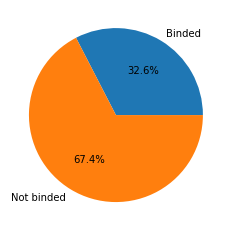

      sequence  class
0    STAFDFLAV      1
1    SQSPSSFSM      1
2    FALGNVISA      1
3    KINLSLFAL      1
4    LLDSLPMDV      1
..         ...    ...
295  YLYDRLLRI      0
296  YLSKIIPAL      0
297  TPTVPSGSF      0
298  VVLSWAPPV      0
299  ARDIYRASY      0

[300 rows x 2 columns]


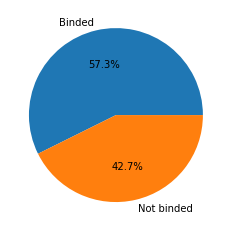

        sequence  class
0      KMVELVHFL      1
1      MIKNLTQLF      1
2      TQDLVQEKY      1
3      LRFPGQLNA      1
4      KVYDKLFPV      1
...          ...    ...
17341  TLNAWVKVV      0
17342  TLRKERLAK      0
17343  FYLYLTFYF      0
17344  FYPINDDFY      0
17345  KLDDVEKEK      0

[17346 rows x 2 columns]


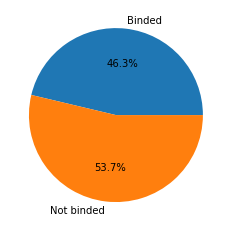

       sequence  class
0     LTMDREMLY      1
1     GMVTLYLGV      1
2     IMSLFSTSA      1
3     SASRAWNVW      1
4     ILIEGVFFA      1
...         ...    ...
2804  IVNNQESNK      0
2805  NEEVAIILA      0
2806  STYGISEDL      0
2807  HAPWTQMAM      0
2808  LSDAARLFL      0

[2809 rows x 2 columns]


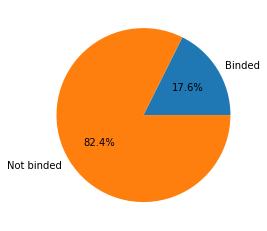

In [4]:
dataset1 = LoadDataset(pos_file='Positive_A0201_9AA_binder_pep.txt', neg_file='Negative_A0201_9AA_nonbinder_pep.txt')
dataset_cancer = LoadDataset(pos_file='dbPepNeo_HC_neoantigens_positive.txt', neg_file='dbPepNeo_HC_neoantigens_negative.txt')
dataset_fxxx = LoadDataset(pos_file='f123_ba_positive.txt', neg_file='f000_ba_negative.txt')
dataset_cxxx = LoadDataset(pos_file='c000_ba_test_positive.txt', neg_file='c000_ba_test_negative.txt')

Experiment: generate 8x400 feature table

In [5]:
scoreTable = BuildBlosum62()
print(scoreTable)

X_list = []
y_list = []
ds_list = [dataset_fxxx, dataset_cxxx, dataset_cancer]
ds_tag = ['ds_fxxx', 'ds_cxxx', 'ds_cancer']

LOAD_EXISTING_DATA = True
if LOAD_EXISTING_DATA:
    for i in range(len(ds_list)):
        store = pd.HDFStore(ds_tag[i]+'.h5')
        X_ = store['X']
        y_ = store['y']
        store.close()
        X_list.append(X_)
        y_list.append(y_)  
else:
    for i in range(len(ds_list)):
        X_ = []
        y_ = []
        start = time.time()
        ds = ds_list[i]
        for index in range(len(ds)):
            #feat = BuildFeature(df=scoreTable, seq=ds.loc[index, 'sequence'], type='sparse')
            feat = BuildFeature(df=scoreTable, seq=ds.loc[index, 'sequence'], type='condense')
            X_.append(feat)
            y_.append(ds.loc[index, 'class'])

        X_ = pd.DataFrame(X_)
        y_ = pd.DataFrame(y_)
        print(X_)

        store = pd.HDFStore(ds_tag[i]+'.h5')
        store['X'] = X_
        store['y'] = y_
        store.close()

        X_list.append(X_)
        y_list.append(y_)
        end = time.time()
        print("Time to build feature vector: {} sec".format(end-start))

X = X_list[0]
y = y_list[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17, stratify=y)
print(X_train)
print(y_train)

   A  R  N  D  C  Q  E  G  H  I  ...  K  M  F  P  S  T   W  Y  V  X
A  4 -1 -2 -2  0 -1 -1  0 -2 -1  ... -1 -1 -2 -1  1  0  -3 -2  0  0
R -1  5  0 -2 -3  1  0 -2  0 -3  ...  2 -1 -3 -2 -1 -1  -3 -2 -3 -1
N -2  0  6  1 -3  0  0  0  1 -3  ...  0 -2 -3 -2  1  0  -4 -2 -3 -1
D -2 -2  1  6 -3  0  2 -1 -1 -3  ... -1 -3 -3 -1  0 -1  -4 -3 -3 -1
C  0 -3 -3 -3  9 -3 -4 -3 -3 -1  ... -3 -1 -2 -3 -1 -1  -2 -2 -1 -2
Q -1  1  0  0 -3  5  2 -2  0 -3  ...  1  0 -3 -1  0 -1  -2 -1 -2 -1
E -1  0  0  2 -4  2  5 -2  0 -3  ...  1 -2 -3 -1  0 -1  -3 -2 -2 -1
G  0 -2  0 -1 -3 -2 -2  6 -2 -4  ... -2 -3 -3 -2  0 -2  -2 -3 -3 -1
H -2  0  1 -1 -3  0  0 -2  8 -3  ... -1 -2 -1 -2 -1 -2  -2  2 -3 -1
I -1 -3 -3 -3 -1 -3 -3 -4 -3  4  ... -3  1  0 -3 -2 -1  -3 -1  3 -1
L -1 -2 -3 -4 -1 -2 -3 -4 -3  2  ... -2  2  0 -3 -2 -1  -2 -1  1 -1
K -1  2  0 -1 -3  1  1 -2 -1 -3  ...  5 -1 -3 -1  0 -1  -3 -2 -2 -1
M -1 -1 -2 -3 -1  0 -2 -3 -2  1  ... -1  5  0 -2 -1 -1  -1 -1  1 -1
F -2 -3 -3 -3 -2 -3 -3 -3 -1  0  ... -3  0  6 -4

[0]	train-auc:0.74925
[1]	train-auc:0.79121
[2]	train-auc:0.80716
[3]	train-auc:0.81406
[4]	train-auc:0.82116
[5]	train-auc:0.82494
[6]	train-auc:0.83094
[7]	train-auc:0.83751
[8]	train-auc:0.84519
[9]	train-auc:0.84861
[10]	train-auc:0.85237
[11]	train-auc:0.85655
[12]	train-auc:0.86279
[13]	train-auc:0.86751
[14]	train-auc:0.87042
[15]	train-auc:0.87295
[16]	train-auc:0.87577
[17]	train-auc:0.87854
[18]	train-auc:0.88326
[19]	train-auc:0.88493
[20]	train-auc:0.88708
[21]	train-auc:0.88997
[22]	train-auc:0.89113
[23]	train-auc:0.89264
[24]	train-auc:0.89391
[25]	train-auc:0.89511
[26]	train-auc:0.89807
[27]	train-auc:0.90163
[28]	train-auc:0.90347
[29]	train-auc:0.90526
[30]	train-auc:0.90706
[31]	train-auc:0.90822
[32]	train-auc:0.91018
[33]	train-auc:0.91348
[34]	train-auc:0.91496
[35]	train-auc:0.91670
[36]	train-auc:0.91876
[37]	train-auc:0.91975
[38]	train-auc:0.92074
[39]	train-auc:0.92163
[40]	train-auc:0.92247
[41]	train-auc:0.92368
[42]	train-auc:0.92525
[43]	train-auc:0.9268

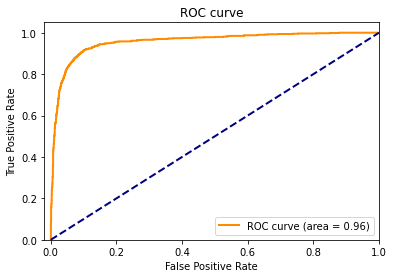

========= dataset cxxx ================
AUC-ROC: 0.9796958347520145


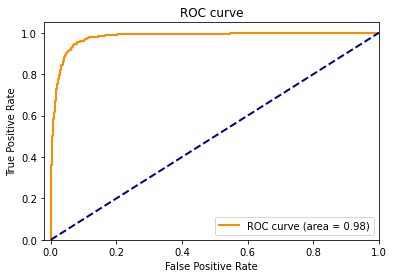

========= dataset cancer ================
[0.79564303 0.16498841 0.6673978  0.4558839  0.57330996 0.8372389
 0.16600505 0.23945017 0.4779309  0.24673149 0.69224155 0.540371
 0.28881735 0.90139216 0.26080558 0.6468011  0.69224155 0.42008042
 0.3540057  0.82473135 0.73511046 0.52272695 0.5707365  0.47662926
 0.09347949 0.2667067  0.2558498  0.60258865 0.35562196 0.14057091
 0.30561838 0.427031   0.17060347 0.6187096  0.31338286 0.7911727
 0.7266214  0.3540057  0.6326266  0.13330235 0.03953588 0.32594925
 0.744276   0.71720284 0.71720284 0.02714394 0.02714394 0.02714394
 0.02714394 0.02714394 0.02714394 0.28270158 0.28270158 0.28270158
 0.28270158 0.28270158 0.05802644 0.05802644 0.5018594  0.5018594
 0.590831   0.590831   0.8147102  0.8147102  0.8147102  0.12987965
 0.8731192  0.6128233  0.32187468 0.25874597 0.3053482  0.1676321
 0.5913964  0.70241475 0.48211077 0.08920261 0.73212695 0.7834192
 0.14747311 0.80988014 0.46338215 0.04133585 0.07434391 0.08535516
 0.2968529  0.5549417  0.84

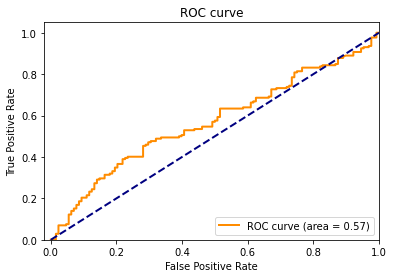

Postive sample prediction stat
count    172.000000
mean       0.419138
std        0.271709
min        0.012561
25%        0.167570
50%        0.371635
75%        0.679836
max        0.901392
Name: pred, dtype: float64
Negative sample prediction stat
count    128.000000
mean       0.348670
std        0.238357
min        0.005935
25%        0.139505
50%        0.296174
75%        0.521443
max        0.972580
Name: pred, dtype: float64
Max AUC: 0.579124273255814 with cutoff 0.4


In [6]:
params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "eta": 0.1,
    "min_child_weight": 1,
    "max_depth": 6,
    "nthread": 4
}

xgb_train = xgb.DMatrix(X_train.values, y_train.values)
xgb_test = xgb.DMatrix(X_test.values)

num_round = 300
watchlist = [(xgb_train, 'train')]
start = time.time()
model = xgb.train(params, xgb_train, num_round, watchlist)
end = time.time()
print("Time to train: {} sec".format(end-start))

print("========= training dataset ================")
y_pred = model.predict(xgb_test)
show_roc_curve(y_test = y_test, y_pred = y_pred)

print("========= dataset cxxx ================")
xgb_test = xgb.DMatrix(X_list[1].values)
y_pred = model.predict(xgb_test)
show_roc_curve(y_test = y_list[1], y_pred = y_pred)

print("========= dataset cancer ================")
xgb_test = xgb.DMatrix(X_list[2].values)
y_pred = model.predict(xgb_test)
print(y_pred)
show_roc_curve(y_test = y_list[2], y_pred = y_pred)

# neg case, prob distribution
dataset_cancer['pred'] = pd.Series(y_pred)

cancer_pos = dataset_cancer[dataset_cancer['class'] == 1]
cancer_neg = dataset_cancer[dataset_cancer['class'] == 0]

print("Postive sample prediction stat")
print(cancer_pos['pred'].describe())
print("Negative sample prediction stat")
print(cancer_neg['pred'].describe())

dataset_cancer.to_csv('ds_cancer_result.csv', index=False, encoding='utf-8')

# grid search cutoff, report auc

def make_pred(x, cutoff):
    return (x > cutoff)

max = 0
res = pd.Series(y_pred)
for c in np.arange(0.1, 1.0, 0.1):
    y_pred_c = res.apply(make_pred, args=(c,))
    auc = roc_auc_score(y_list[2], y_pred_c)
    if auc > max:
        max = auc
        max_cutoff = c
        y_pred_cutoff = y_pred_c

print("Max AUC: {} with cutoff {}".format(max, max_cutoff))